## Import required packages

In [19]:
from typing import Dict, List, Tuple

import tqdm

import numpy as np
import pandas as pd

import scipy
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt

import pathlib
import tttrlib

import os

from feda_tools import twodim_hist as tdh
from feda_tools import utilities as utils
from feda_tools import analysis as an

from decimal import Decimal, getcontext

import numpy.ma as ma
from scipy.stats import norm
from scipy.stats import halfnorm

## Declare required functions

In [20]:
def calc_flour_aniso(g_factor, intensity_para, intensity_perp, l1_japan_corr, l2_japan_corr):
    ### Fluorescence Anisotropy calculation. see equation 7 in Kudryavtsev, V., Sikor, M., Kalinin, S., Mokranjac, D., Seidel, C.A.M. and Lamb, D.C. (2012), 
    ### Combining MFD and PIE for Accurate Single-Pair Förster Resonance Energy Transfer Measurements. ChemPhysChem, 13: 1060-1078. https://doi.org/10.1002/cphc.201100822
    
    return (g_factor * intensity_para - intensity_perp) / ((1 - 3 * l2_japan_corr) * g_factor * intensity_para + (2 - 3 * l1_japan_corr) * intensity_perp)

## Load target PTU file

In [21]:
# Load PTU Files
# file_path = pathlib.Path('//130.127.188.19/projects/FoxP_FKH-DNA/20220314_FoxP1_data_all_NK/20220310_V78C_monomer_NK/V78C_monomer_FoxP1_1hr/burstwise_All 0.2027#30')
# bid_path = pathlib.Path('//130.127.188.19/projects/FoxP_FKH-DNA/20220314_FoxP1_data_all_NK/20220310_V78C_monomer_NK/V78C_monomer_FoxP1_1hr/burstwise_All 0.2027#30/BIDs_30ph')

### for testing purposes ###
# file_path = pathlib.Path('C:/Users/2administrator/Documents/source/repos/feda_tools/test data/2022/03_02_22_Troubleshooting_detection_efficiencies/Combined_old_thresholds/Split_After_Adjust_HF_54000s_pinhole6-000000.ptu')

# #total time 816.9 seconds for this file
# dir = 'C:/Users/2administrator/Documents/source/repos/feda_tools/test data/2022/03_02_22_Troubleshooting_detection_efficiencies/'
# file_ptu = dir + 'Combined_old_thresholds/Split_After_Adjust_HF_54000s_pinhole6-000000.ptu'
# file_irf = dir + 'H2O_300s_adjust_thresholds.ptu'
# file_bkg = dir + 'PBS_300s_adjust_thresholds.ptu'


In [22]:
# Load PTU Files
# file_path = pathlib.Path('//130.127.188.19/projects/FoxP_FKH-DNA/20220314_FoxP1_data_all_NK/20220310_V78C_monomer_NK/V78C_monomer_FoxP1_1hr/burstwise_All 0.2027#30')
# bid_path = pathlib.Path('//130.127.188.19/projects/FoxP_FKH-DNA/20220314_FoxP1_data_all_NK/20220310_V78C_monomer_NK/V78C_monomer_FoxP1_1hr/burstwise_All 0.2027#30/BIDs_30ph')

### for testing purposes ###
# file_path = pathlib.Path('C:/Users/2administrator/Documents/source/repos/feda_tools/test data/2022/03_02_22_Troubleshooting_detection_efficiencies/Combined_old_thresholds/Split_After_Adjust_HF_54000s_pinhole6-000000.ptu')

#total time 816.9 seconds for this file
dir = 'C:/Users/2administrator/Documents/source/repos/feda_tools/test data/2024/'
file_ptu = dir + 'Split_20230809_HighFRETDNAStd_1hr_Dani-000000.ptu'
file_irf = dir + '20230809_IRFddH2O_Dani_5min.ptu'
file_bkg = dir + '20230809_bg_HighFRETDNAStd_30sec_Dani.ptu'


## Initialize tttrlib data and extract important global data

In [23]:
data_ptu = tttrlib.TTTR(file_ptu, 'PTU')
all_macro_times = data_ptu.macro_times
all_micro_times = data_ptu.micro_times
routing_channels =  data_ptu.routing_channels

data_irf = tttrlib.TTTR(file_irf, 'PTU')
all_macro_times_irf = data_irf.macro_times
all_micro_times_irf = data_irf.micro_times
routing_channels_irf =  data_irf.routing_channels

data_bkg = tttrlib.TTTR(file_bkg, 'PTU')
all_macro_times_bkg = data_bkg.macro_times
all_micro_times_bkg = data_bkg.micro_times
routing_channels_bkg =  data_bkg.routing_channels

#in seconds. usually the first plots are in ms to see the bursts.
macro_res =data_ptu.get_header().macro_time_resolution
micro_res = data_ptu.get_header().micro_time_resolution

# total duration in seconds
total_duration = all_macro_times[-1] * macro_res

# define analysis window for subset of PTU
min_event = 0
max_event = 300000

IndexError: index -1 is out of bounds for axis 0 with size 0

## Determine analysis settings for bur, bg4, by4, and br4 calculations.

In [6]:
# photon count threshold for burst selection
min_photon_count = 60

# this window changes for br4 and by4
# bg4 parameters
bg4_micro_time_min = 0
bg4_micro_time_max = 12499

# flourescence anisotropy parameters
g_factor = 1.04
l1_japan_corr = 0.0308
l2_japan_corr = 0.0368

# # bkg signals required for r Scatter calculations
bg4_bkg_para = 0
bg4_bkg_perp = 0


# MLE parameters
num_bins = 128
bin_width = macro_res/micro_res/num_bins/1000 # in nanoseconds

## Calculate interphoton arrival time 

In [7]:
#iterate through macro and micro times to calculate delta time between photon events
arr_size = len(all_macro_times) - 1
photon_time_intervals = np.zeros(arr_size, dtype = np.float64)
lw = 0.25
for i in range(0, len(photon_time_intervals)):
    photon_1 = (all_macro_times[i]*macro_res) + (all_micro_times[i]*micro_res)
    photon_2 = (all_macro_times[i+1]*macro_res) + (all_micro_times[i+1]*micro_res)
    photon_time_intervals[i] = (photon_2 - photon_1)*1000

# create photon ID array
photon_ids = np.arange(1, arr_size + 1)


In [8]:
print(photon_time_intervals[-1])

0.14390862645541347


## Plot the Raw Data

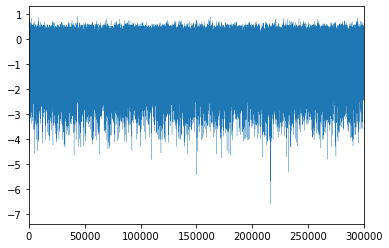

In [9]:
# plot interactive
# %matplotlib qt

# raw data, no running average
plt.plot(photon_ids, np.log10(photon_time_intervals), linewidth = 0.25)
plt.xlim(min_event, max_event)
plt.show()

## Plot the log of the running average

In [10]:
def running_average(data, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

# Create a NumPy array
data = photon_time_intervals

# Set the window size for the running average
window_size = 30

# Calculate the running average
running_avg = running_average(data, window_size)



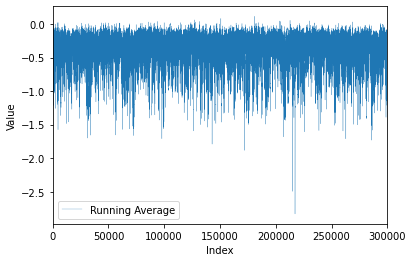

In [11]:
# Plot the running average
# plt.plot(data, label='Original Data')
lw = 0.25
xarr = np.arange(window_size - 1, len(data))
logrunavg = np.log10(running_avg)
plt.plot(xarr, logrunavg, label='Running Average', linewidth = lw)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.xlim(min_event, max_event)
plt.show()

## Plot the log of the running average using 2D heat map to better visualize noise

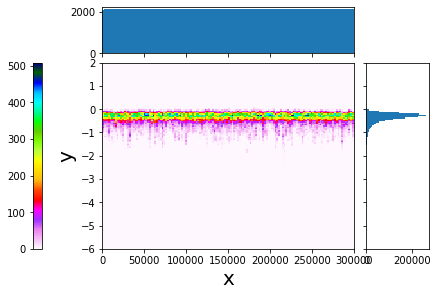

In [12]:
# plot the running average as a 2D histogram with 1D histograms on the margins

bins = {"x":141, "y": 141}
xrange = {"min" : min_event, "max" : max_event}
yrange = {"min" : -6, "max" : 2}
fig, ax, twodimdata = tdh.make_plot(xarr, logrunavg, "x", "y",xrange ,yrange, bins)

## Visually estimate the mean of the Gaussian background noise 


#### Vary the mean value and plot to check if the estimated mean is well aligned with the peak of the noise. The data on the right-half (blue/purple) estimates the right half of the Gaussian noise. The left-most bin of the right-half data is the estimated mean. When the estimated mean is well aligned with the peak, then you may continue to the next step.

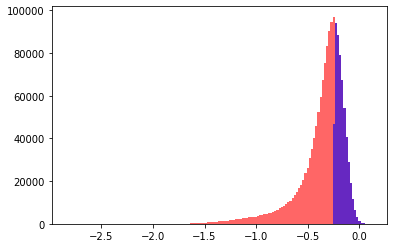

In [13]:
### estimate the half gaussian fit on the top half of the data.
# set the threshold based on visual inspection. here, threshold ~ mu
noise_mean = -0.25

# compress the filtered data to remove the masked values
filtered_logrunavg = ma.masked_less(logrunavg, noise_mean).compressed()

# Set all masked values to zero
counts_logrunavg, bins_logrunavg, _ = plt.hist(logrunavg, bins = bins['y'], alpha=0.6, color='r')
plt.hist(filtered_logrunavg, bins = bins_logrunavg, alpha=0.6, color='b')
plt.show()

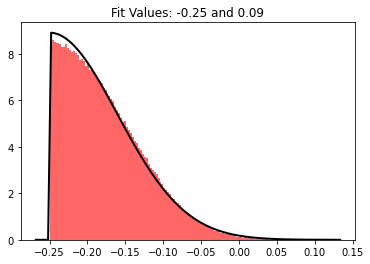

In [14]:
# fit with halfnorm. visualize for best fit testing. get mu and std dev. consider finding max and setting location as mean
mu, std = halfnorm.fit(filtered_logrunavg)

# counts_logrunavg, bins_logrunavg, _ = plt.hist(logrunavg, bins = bins['y'], density= True, alpha=0.6, color='r')
plt.hist(filtered_logrunavg, bins = bins['y'], density = True, alpha=0.6, color='r')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = halfnorm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

# Display the plot
plt.show()

## Using the halfnorm fit on top half of background noise, define 4sigma threshold to isolate the dynamics data and then plot for inspection.

In [15]:
### Using std from halfnorm fit, set the threshold for filtering out noise. Then, filter out noise. Raise 10 to threshold later for burst selection
threshold_value = mu - 4*std #raise 10 to the power of this threshold to obtain the threshold in Paris.
filtered_values = ma.masked_greater(logrunavg, threshold_value)

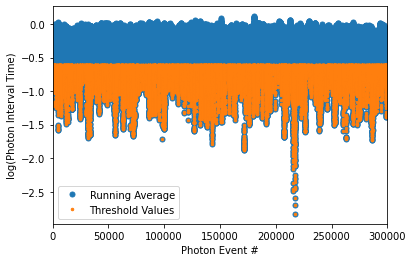

In [16]:
# visualize the log running average and the threshold values
plt.plot(xarr, logrunavg, label='Running Average', linestyle='None', marker = 'o', markersize = 5)
plt.plot(xarr, filtered_values, label='Threshold Values', linestyle='None', marker = '.', markersize = 5)
plt.xlabel('Photon Event #')
plt.ylabel('log(Photon Interval Time)')
plt.legend()
plt.xlim(min_event, max_event)
plt.show()

## Extract the photon data that meets the threshold condition and create a burst index for further calculations

In [17]:
### define function for extracting the unmasked segments from the thresholded data.
def extract_unmasked_indices(masked_array):
    unmasked_indices_lists = []
    current_indices = []

    # iterate through masked array and collect unmasked index segments
    for i, value in enumerate(masked_array):
        if np.ma.is_masked(value):
            if current_indices:
                unmasked_indices_lists.append(current_indices)
                current_indices = []
        else:
            current_indices.append(i)

    # handle the last segment
    if current_indices:
        unmasked_indices_lists.append(current_indices)

    return unmasked_indices_lists

In [18]:
### Get a burst index. Each list is a burst, and each list contains the indices of 
### the photon events in the original data.
burst_index = extract_unmasked_indices(filtered_values)

## Create bi4_bur dataframe and calculate statistics

In [19]:
################################
### create bi4_bur dataframe ###
################################

# prepare empty dataframes to insert calculated burst values
bi4_bur_df = pd.DataFrame()
bg4_df = pd.DataFrame()

bg4_channel_2_photons_total = list()
bg4_channel_0_photons_total = list()

### calculate each burst record and store in df
for burst in burst_index:

    # filter out bursts with one or less photons.
    if len(burst) <= min_photon_count:
        continue

    ############################# .bur calculations
    
    #############################
    ### First and Last Photon ###
    #############################
    
    first_photon = burst[0]
    last_photon = burst[-1]

    ##########################
    ### Duration (ms) calc ###
    ##########################
    
    lp_time = all_macro_times[last_photon]*macro_res + all_micro_times[last_photon]*micro_res
    fp_time = all_macro_times[first_photon]*macro_res + all_micro_times[first_photon]*micro_res
    lp_time_ms = lp_time*1000
    fp_time_ms = fp_time*1000
    duration = (lp_time_ms - fp_time_ms)

    #################################
    ### Mean Macro Time (ms) Calc ###
    #################################
    
    # get all the macro times corresponding to the photons in this burst
    macro_times = all_macro_times[burst[0]]*macro_res*1000
    
    # calculate the mean
    mean_macro_time = np.mean(macro_times)

    ##############################
    ### Number of Photons calc ###
    ##############################
    num_photons = len(burst)

    #######################
    ### Count Rate calc ###
    #######################
    count_rate = num_photons / duration

    #################################
    ### Duration (green)(ms) calc ###
    #################################
    
    # Assuming you have your list of indexes
    list_of_indexes = burst
    
    # Create boolean masks for channels 0 and 2 to select the green channels
    mask_channel_0 = routing_channels[list_of_indexes] == 0
    mask_channel_2 = routing_channels[list_of_indexes] == 2
    
    # Use boolean masks to filter the indexes
    indexes_channel_0 = np.array(list_of_indexes)[mask_channel_0]
    indexes_channel_2 = np.array(list_of_indexes)[mask_channel_2]
    
    # Output the filtered indexes
    # print("Indexes corresponding to channel 0:", indexes_channel_0)
    # print("Indexes corresponding to channel 2:", indexes_channel_2)
    
    # Find the minimum and maximum indexes across both resulting arrays. These are first and last green 
    # photon in this burst. handle situations where only one channel has photons or none have photons.
    if len(indexes_channel_0) > 0 and len(indexes_channel_2) > 0:
        first_green_photon = min(np.min(indexes_channel_0), np.min(indexes_channel_2))
        last_green_photon = max(np.max(indexes_channel_0), np.max(indexes_channel_2))
    elif len(indexes_channel_0) >= 2:
        first_green_photon = np.min(indexes_channel_0)
        last_green_photon = np.max(indexes_channel_0)
    elif len(indexes_channel_2) >= 2:
        first_green_photon = np.min(indexes_channel_2)
        last_green_photon = np.max(indexes_channel_2)
    else:
        first_green_photon = None
        last_green_photon = None

    # Calculate duration or set as NaN
    if first_green_photon != None and last_green_photon != None:
        lgp_time = all_macro_times[last_green_photon]*macro_res + all_micro_times[last_green_photon]*micro_res
        fgp_time = all_macro_times[first_green_photon]*macro_res + all_micro_times[first_green_photon]*micro_res
        lgp_time_ms = lgp_time*1000
        fgp_time_ms = fgp_time*1000
        duration_green = (lgp_time_ms - fgp_time_ms)
    else:
        duration_green = np.nan

    #########################################
    #### Mean Macro Time (green)(ms) calc ###
    #########################################
    
    # get all the macro times corresponding to the photons in this burst
    macro_times_ch0 = all_macro_times[indexes_channel_0]*macro_res*1000
    macro_times_ch2 = all_macro_times[indexes_channel_2]*macro_res*1000
    
    # Concatenate the arrays along the appropriate axis
    combined_macro_times = np.concatenate([macro_times_ch0, macro_times_ch2], axis=0)
    
    # calculate the mean
    mean_macro_time_green = np.mean(combined_macro_times, axis=0)

    #################################
    ### Number of Photons (green) ###
    #################################
    num_photons_gr = len(indexes_channel_0) + len(indexes_channel_2)

    ########################
    ### Green Count Rate ###
    ########################
    count_rate_gr = num_photons_gr / duration_green

    bur_new_row = {'First Photon': [first_photon],'Last Photon': [last_photon],
               'Duration (ms)': [duration],'Mean Macro Time (ms)': [mean_macro_time],
               'Number of Photons': [num_photons], 'Count Rate (kHz)': [count_rate],
               'Duration (green) (ms)': [duration_green], 
               'Mean Macro Time (green) (ms)': [mean_macro_time_green],
               'Number of Photons (green)': [num_photons_gr],
               'Green Count Rate (kHz)': count_rate_gr
              }
    
    bur_new_record = pd.DataFrame.from_dict(bur_new_row)
    
    ### append record to df
    bi4_bur_df = pd.concat([bi4_bur_df, bur_new_record], ignore_index=True)

    ######################## .bg4 calculations

    ################
    ### Ng-p-all ###
    ################

    # Find the indices in burst where the corresponding channel is 2 and 0 < micro time < 12499 using list comprehension
    bg4_channel_2_photons = [index for index in burst if routing_channels[index] == 2 and 
                                 bg4_micro_time_min < all_micro_times[index] < bg4_micro_time_max]
    bg4_channel_2_count = len(bg4_channel_2_photons)

    # append bg4 chn 2 photons to total list for MLE estimations later
    bg4_channel_2_photons_total.extend(bg4_channel_2_photons)


    ################
    ### Ng-s-all ###
    ################

    # Find the indices in burst where the corresponding channel is 0 using list comprehension
    bg4_channel_0_photons = [index for index in burst if routing_channels[index] == 0 and 
                                 bg4_micro_time_min < all_micro_times[index] < bg4_micro_time_max]
    bg4_channel_0_count = len(bg4_channel_0_photons)

    # append bg4 chn 0 photons to total list for MLE estimations later
    bg4_channel_0_photons_total.extend(bg4_channel_0_photons)

    ##############################################
    ### Number of Photons (fit window) (green) ###
    ##############################################

    bg4_total_count = bg4_channel_2_count + bg4_channel_0_count

    ##############################
    ### r Experimental (green) ###
    ##############################

    bg4_rexp = calc_flour_aniso(g_factor, bg4_channel_2_count, bg4_channel_0_count, l1_japan_corr, l2_japan_corr)

    #########################
    ### r Scatter (green) ###
    #########################

    bg4_rscat = calc_flour_aniso(g_factor, bg4_channel_2_count - bg4_bkg_para, bg4_channel_0_count - bg4_bkg_perp, l1_japan_corr, l2_japan_corr)

    ### create and store new record for this burst 

    bg4_new_row = {'Ng-p-all': [bg4_channel_2_count],
                   'Ng-s-all': [bg4_channel_0_count],
                   'Number of Photons (fit window) (green)' : [bg4_total_count],
                   'r Scatter (green)' : [bg4_rscat],
                   'r Experimental (green)' : [bg4_rexp]
                  }
    bg4_new_record = pd.DataFrame.from_dict(bg4_new_row)
    
    ### append record to df
    bg4_df = pd.concat([bg4_df, bg4_new_record], ignore_index=True)
    

## Save the bi4_bur, bg4, br4 and by4 to csv

In [20]:
# put output directory at the start

output_directory = r'C:\Users\2administrator\Documents\source\repos\feda_tools\tests\burstid_selection_viz_tool'
bur_filename = os.path.splitext(os.path.basename(file_p))[0]
bur_filepath = os.path.join(output_directory,bur_filename) + ".bur"
bi4_bur_df.to_csv(bur_filepath, sep='\t', index=False, float_format='%.6f')  # Save without index

NameError: name 'file_p' is not defined

In [ ]:
bur_filename = os.path.splitext(os.path.basename(file_p))[0]
bur_filepath = os.path.join(output_directory,bur_filename) + ".bg4"
bg4_df.to_csv(bur_filepath, sep='\t', index=False, float_format='%.6f')  # Save without index

## Mean Micro Time Testing

In [24]:
import numpy as np

# Assuming you have the arrays: bg4_channel_0_photons, bg4_channel_2_photons, and all_micro_times

# Extract micro times for channel 0 photons
micro_times_channel_0 = all_micro_times[bg4_channel_0_photons]

# Extract micro times for channel 2 photons
micro_times_channel_2 = all_micro_times[bg4_channel_2_photons]

# photon counts
count_chn0 = len(bg4_channel_0_photons)
count_chn2 = len(bg4_channel_2_photons)

#p and s mean micro times
mean_microtime_chn0 = np.mean(micro_times_channel_0)
mean_microtime_chn2 = np.mean(micro_times_channel_2)

mean_microtime_total = ( count_chn2 * mean_microtime_chn2 + 2 * count_chn0 * mean_microtime_chn0 ) / ( count_chn2 + 2 * count_chn0 )

# Output the combined mean micro time
print("mean micro time for channels 0 and 2 photons:", mean_microtime_total)

NameError: name 'bg4_channel_0_photons' is not defined

In [22]:
import numpy as np

# Assuming you have the arrays: bg4_channel_0_photons, bg4_channel_2_photons, and all_micro_times

# Extract micro times for channel 0 photons
micro_times_channel_0 = all_micro_times[bg4_channel_0_photons_total]

# Extract micro times for channel 2 photons
micro_times_channel_2 = all_micro_times[bg4_channel_2_photons_total]

# Calculate the mean micro time for channel 0 photons
mean_micro_time_channel_0 = np.mean(micro_times_channel_0)

# Calculate the mean micro time for channel 2 photons
mean_micro_time_channel_2 = np.mean(micro_times_channel_2)

# Calculate the mean of the means
combined_mean_micro_time = np.mean([mean_micro_time_channel_0, mean_micro_time_channel_2])

# Output the combined mean micro time
print("Combined mean micro time for channels 0 and 2 photons:", combined_mean_micro_time)


Combined mean micro time for channels 0 and 2 photons: 2799.5526509413203


## Visualize the micro time decay curves for the entire bg4 data set.

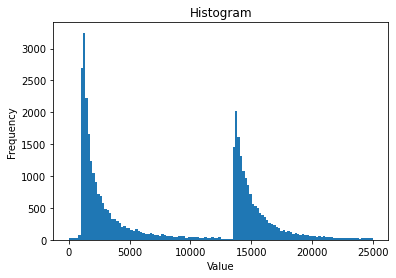

In [23]:
# This data can be used prior to performing burst by burst mle fitting to determine the initial fitting parameters tau, gamma, r0, and rho.

### plot the histogram of the ptu file

# Add 12499 to parallel photon microtimes
micro_times_channel_0_shifted = micro_times_channel_0 + 12499

# Extract micro times for channel 2 photons
micro_times_channel_2 = all_micro_times[bg4_channel_2_photons_total]

chn0_shifted_plus_chn2 = np.concatenate([micro_times_channel_0_shifted, micro_times_channel_2])

num_bins = 128
# Plot the histogram with 128 bins
counts, bins, _ = plt.hist(chn0_shifted_plus_chn2, bins=num_bins)


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

# Extract the binned data
# print("Counts for each bin:", counts)
# print("Bin edges:", bins)

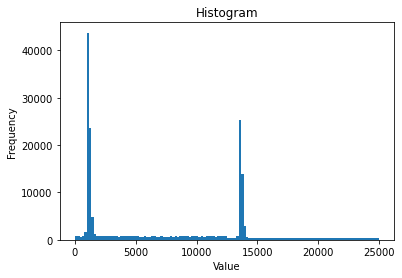

In [24]:
### plot the histogram of the irf

# Find the indices in IRF where the corresponding channel is 2 and 0 
channel_2_photons_irf = [index for index, channel in enumerate(routing_channels_irf) if channel == 2 and 
                                 bg4_micro_time_min < all_micro_times_irf[index] < bg4_micro_time_max]
channel_0_photons_irf = [index for index, channel in enumerate(routing_channels_irf) if channel == 0 and 
                                 bg4_micro_time_min < all_micro_times_irf[index] < bg4_micro_time_max]

# Add 12499 to parallel photon microtimes
micro_times_channel_0_irf = all_micro_times_irf[channel_0_photons_irf]
micro_times_channel_0_shifted_irf = micro_times_channel_0_irf + 12499

# Extract micro times for channel 2 photons
micro_times_channel_2_irf = all_micro_times_irf[channel_2_photons_irf]

# Combine channel 0 and 2 irf data for plotting
chn0_shifted_plus_chn2_irf = np.concatenate([micro_times_channel_0_shifted_irf, micro_times_channel_2_irf])

# Plot the irf data
counts_irf, bins_irf, _ = plt.hist(chn0_shifted_plus_chn2_irf, bins=num_bins)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

# Extract the binned data
# print("Counts for each bin:", counts)
# print("Bin edges:", bins)

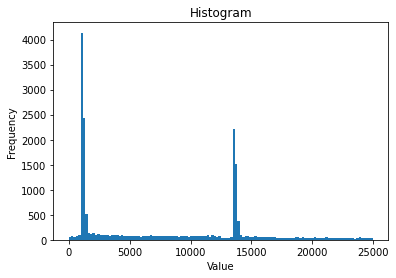

In [25]:
### plot the histogram of the bkg

# Find the indices in bkg where the corresponding channel is 2 and 0 
channel_2_photons_bkg = [index for index, channel in enumerate(routing_channels_bkg) if channel == 2 and 
                                 bg4_micro_time_min < all_micro_times_bkg[index] < bg4_micro_time_max]
channel_0_photons_bkg = [index for index, channel in enumerate(routing_channels_bkg) if channel == 0 and 
                                 bg4_micro_time_min < all_micro_times_bkg[index] < bg4_micro_time_max]

# Add 12499 to parallel photon microtimes
micro_times_channel_0_bkg = all_micro_times_bkg[channel_0_photons_bkg]
micro_times_channel_0_shifted_bkg = micro_times_channel_0_bkg + 12499

# Extract micro times for channel 2 photons
micro_times_channel_2_bkg = all_micro_times_bkg[channel_2_photons_bkg]

# Combine channel 0 and 2 bkg data for plotting
chn0_shifted_plus_chn2_bkg = np.concatenate([micro_times_channel_0_shifted_bkg, micro_times_channel_2_bkg])

# Plot the bkg data
counts_bkg, bins_bkg, _ = plt.hist(chn0_shifted_plus_chn2_bkg, bins=num_bins)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

# Extract the binned data
# print("Counts for each bin:", counts)
# print("Bin edges:", bins)

## Estimate tau, gamma, r0, and rho using fit23

In [26]:
# estimate tau, gamma, r0, and rho using fit23

# is the width of the bins in time
dt = 25000/num_bins/1000

# period is pulse duration of the laser (50ns)
period = 1/macro_res/np.power(10,6)

# irf_np = np.zeros_like(counts)

# irf_np = np.array([260, 158200000, 155, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 22, 107400000, 830, 10, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0], dtype=np.float64)

# count_bkg = np.zeros_like(counts_irf)

#### SET IRF to zero from channel 5 to channl 64 and 70 to 128 to remove IRF background
# counts_irf[5:64] = 0
# counts_irf[70:128] = 0

fit23 = tttrlib.Fit23(
    dt=dt,
    # irf=irf_np,
    irf=counts_irf,
    background=counts_bkg,
    period=period,
    g_factor=g_factor,
    l1=l1_japan_corr, l2=l2_japan_corr,
    convolution_stop = 6,
    p2s_twoIstar_flag = True
)

# normalize counts
norm_counts = counts/np.max(counts)

tau, gamma, r0, rho = 3.03, 0.24, 0.38, 0.64
x0 = np.array([tau, gamma, r0, rho])
fixed = np.array([1, 1, 1, 1])
r2 = fit23(data=counts, initial_values=x0, fixed=fixed, include_model = True)
print(r2)
# output key from DecayFit23.h on tttrlib github.
# x[0] fluorescence lifetime - tau;
# x[1] fraction of scattered light - gamma;
# x[2] fundamental anisotropy - r0
# x[3] rotational time - rho;
# x[4] softbifl - flag specifying the type of bifl fit (not used here)
# x[5] p2s_twoIstar - flag specifying the type of chi2 calculation (not used here)
# x[6] background corrected anisotropy
# x[7] anisotropy without background correction

{'x': array([ 3.03000000e+000,  1.39363484e-311,  3.80000000e-001,
        6.40000000e-001, -1.00000000e+000,  1.00000000e+000,
       -5.44564769e+000,  7.62028214e-002]), 'fixed': array([1, 1, 1, 1], dtype=int16), 'twoIstar': 1170.3519609482244, 'model': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])}


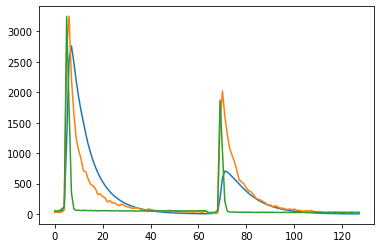

<tttrlib.tttrlib.MParam; proxy of <Swig Object of type 'MParam *' at 0x00000290EE5EC0C0> >


In [27]:
import pylab as p

# estimate using MLE example 2

# is the width of the bins in time
dt = 25000/num_bins/1000

# period is pulse duration of the laser (50ns)
period = 1/macro_res/np.power(10,6)

# irf_np = np.zeros_like(counts)

# irf_np = np.array([260, 158200000, 155, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 22, 107400000, 830, 10, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0], dtype=np.float64)

count_bkg = np.zeros_like(counts_irf)

# conv_stop = num_bins // 2 /- 1
conv_stop = 12


corrections = np.array([period, g_factor, l1_japan_corr, l2_japan_corr, conv_stop])
m_param = tttrlib.CreateMParam(
    irf=counts_irf,
    background=counts_bkg,
    data = counts.astype(np.int32),
    corrections = corrections,
    dt=dt
)


tau, gamma, r0, rho = 4.0, 0.01, 0.38, 1.5
bifl_scatter = -1
p_2s = 0

x = np.zeros(8, dtype=np.float64)
x[:6] = [tau, gamma, r0, rho, bifl_scatter, p_2s]

fixed = np.array([0, 1, 1, 1], dtype=np.int16)
chi2 = tttrlib.DecayFit23.fit(x, fixed, m_param)

m = np.array([m for m in m_param.get_model()])
p.plot(m)
p.plot(counts)
p.plot(counts_irf / max(counts_irf) * max(counts))
p.show()

print(m_param)

## Use MLE data to 

In [28]:
# from plot fit23 benchmark article online

param = np.array([3.03, 0.24, 0.38, 0.64])

# flourescence anisotropy parameters
g_factor = 1.04
l1_japan_corr = 0.0308
l2_japan_corr = 0.0368
conv_stop = 6

corrections = np.array([period, g_factor, l1_japan_corr, l2_japan_corr, conv_stop])
model = np.zeros_like(counts_irf)
tttrlib.DecayFit23.modelf(param, counts_irf, counts_bkg, dt, corrections, model)

# n_photons = len(chn0_shifted_plus_chn2) # normalize for some reason. see tttrlib fit23 benchmark article.
# model *= n_photons / np.sum(model)
# data = np.random.poisson(model * n_photons)
# plt.plot(data)

0

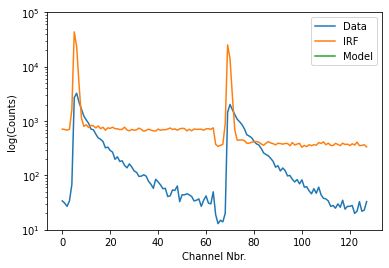

In [29]:
# %matplotlib qt
plt.semilogy([x for x in fit23.data], label='Data')
plt.semilogy([x for x in fit23.irf], label='IRF')
plt.semilogy([x for x in fit23.model], label='Model')
# Set the y-axis limits
plt.ylim(10, 100000)
# plt.title.set_text(r'Example decay')
plt.ylabel(r'log(Counts)')
plt.xlabel(r'Channel Nbr.')
plt.legend()

In [30]:
# get MLE to fit mean micro time decays. extract model parameters. use to fit each burst and extract lifetimes from bursts.
# how many bursts per second are selected and how many bursts per seconds after filter. before and after thresdhol, what is the burst per second? Single molecule order of mag is 2-3 burst per second byt the time you have lifetimes.

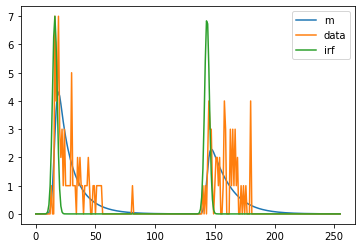

In [31]:
import tttrlib
import numpy as np
import scipy.stats
import pylab as p


def model_irf(
        n_channels: int = 256,
        period: float = 32,
        irf_position_p: float = 2.0,
        irf_position_s: float = 18.0,
        irf_width: float = 0.25
):
    time_axis = np.linspace(0, period, n_channels * 2)
    irf_np = scipy.stats.norm.pdf(time_axis, loc=irf_position_p, scale=irf_width) + \
             scipy.stats.norm.pdf(time_axis, loc=irf_position_s, scale=irf_width)
    return irf_np, time_axis


# setup some parameters
n_channels = 128
n_corrections = 5
n_photons = 120
irf_position_p = 2.0
irf_position_s = 18.0
irf_width = 0.25
period, g, l1, l2, conv_stop = 32, 1.0, 0.1, 0.1, n_channels // 2 - 1
tau, gamma, r0, rho = 2.0, 0.01, 0.38, 1.2
np.random.seed(0)

irf_np, time_axis = model_irf(
    n_channels=n_channels,
    period=period,
    irf_position_p=irf_position_p,
    irf_position_s=irf_position_s,
    irf_width=irf_width
)
dt = time_axis[1] - time_axis[0]
conv_stop = min(len(time_axis), conv_stop)
param = np.array([tau, gamma, r0, rho])
corrections = np.array([period, g, l1, l2, conv_stop])

# compute a model function that is later used as "data"
model = np.zeros_like(time_axis)
bg = np.zeros_like(time_axis)
tttrlib.DecayFit23.modelf(param, irf_np, bg, dt, corrections, model)
# add poisson noise to model and use as data
data = np.random.poisson(model * n_photons)

# create MParam structure that contains all parameters for fitting
m_param = tttrlib.CreateMParam(
    irf=irf_np,
    background=bg,
    data=data.astype(np.int32),
    corrections=corrections,
    dt=dt
)

tau, gamma, r0, rho = 4., 0.01, 0.38, 1.5
bifl_scatter = -1
p_2s = 0
x = np.zeros(8, dtype=np.float64)
x[:6] = [tau, gamma, r0, rho, bifl_scatter, p_2s]

# test fitting
fixed = np.array([0, 1, 1, 1], dtype=np.int16)
chi2 = tttrlib.DecayFit23.fit(x, fixed, m_param)

m = np.array([m for m in m_param.get_model()])
p.plot(m, label = 'm')
p.plot(data, label = 'data')
p.plot(irf_np / max(irf_np) * max(data), label = 'irf')
plt.legend()
p.show()

In [1]:
# create MParam structure that contains all parameters for fitting
# is the width of the bins in time
dt = 25000/num_bins/1000

# period is pulse duration of the laser (50ns)
period = 1/macro_res/np.power(10,6)

# flourescence anisotropy parameters
g_factor = 1.04
l1_japan_corr = 0.0308
l2_japan_corr = 0.0368
conv_stop = 128
corrections = np.array([period, g_factor, l1_japan_corr, l2_japan_corr, conv_stop])

data = counts

m_param = tttrlib.CreateMParam(
    irf=counts_irf,
    background=counts_bkg,
    data=data.astype(np.int32),
    corrections=corrections,
    dt=dt
)

tau, gamma, r0, rho = 3.03, 0.24, 0.38, 0.64
bifl_scatter = 0
p_2s = 1
x = np.zeros(8, dtype=np.float64)
x[:6] = [tau, gamma, r0, rho, bifl_scatter, p_2s]

# test fitting
fixed = np.array([0, 0, 1, 0], dtype=np.int16)
chi2 = tttrlib.DecayFit23.fit(x, fixed, m_param)

m = np.array([m for m in m_param.get_model()])
plt.plot(m, label = 'm')
plt.plot(data, label = 'data')
plt.plot(counts_irf / max(counts_irf) * max(data), label = 'irf')
plt.legend()
plt.show()

NameError: name 'num_bins' is not defined

In [2]:
plt.semilogy([x for x in m], label = 'm')
plt.semilogy([x for x in data], label = 'data')
# plt.semilogy([x for x in fit23.model], label='Model')
# Set the y-axis limits
plt.ylim(10, 100000)

NameError: name 'plt' is not defined